# Initial Set Up

## Importing libraries

In [1]:
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, Adadelta
 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from modules.helpers import load_data

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow_experiment_id = 173184969061571471
mlflow.autolog(disable=True)

2024-04-27 12:12:20.494203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data('dnn')

# Hyper Parameter Tuning

In [3]:
run = False

In [5]:
def create_model(activation='relu',
                 dropout_rate=0.2, 
                 optimizer=Adam,
                 learning_rate=0.01):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(51,)),
        Dropout(dropout_rate),  
        Dense(64, activation=activation),  
        Dropout(dropout_rate),  
        Dense(32, activation=activation),  
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid') 
    ])
    opt = optimizer(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,  
        loss='binary_crossentropy',  
        metrics=['accuracy']  
    )
    
    return model

In [6]:
param_grid = {
    'activation': ['relu', 'softplus', 'sigmoid', 'tanh'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'optimizer': [Adam, SGD, Adadelta],  
    'learning_rate': [0.005, 0.01]  
}

param_configs = [
    {
        'activation': activation,
        'dropout_rate': dropout_rate,
        'optimizer': optimizer,
        'learning_rate': learning_rate,
    }
    for activation in param_grid['activation']
    for dropout_rate in param_grid['dropout_rate']
    for optimizer in param_grid['optimizer']
    for learning_rate in param_grid['learning_rate']
]

In [7]:
if run == True:
    for i in range(len(param_configs)):   
        param_config = param_configs[i]
        with mlflow.start_run(experiment_id=mlflow_experiment_id):
            for param, value in param_config.items():
                mlflow.log_param(param, value)
            
            model = create_model(**param_config)

            history = model.fit(train_x,
                    train_y,
                    epochs=15,
                    batch_size=50,
                    validation_data=(val_x, val_y))
            
            mlflow.log_metric("Accuracy", history.history['val_accuracy'][-1])
            mlflow.log_metric("Loss", history.history['val_loss'][-1])
            
            # Log Model
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path=f'dnn-{i}',
                registered_model_name=f'dnn-{i}'
                )
            
            del model, history
else:
    print("No new runs added")

No new runs added


# Final Model

In [8]:
model = create_model(activation='sigmoid',
                     dropout_rate=0.3,
                     optimizer=Adam,
                     learning_rate=0.005)

model.fit(train_x,
          train_y,
          epochs=15,
          batch_size=50,
          validation_data=(val_x, val_y))

Epoch 1/15


2024-04-27 12:12:23.190340: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


905/905 [==============================] - 5s 5ms/step - loss: 0.5532 - accuracy: 0.7194 - val_loss: 0.5186 - val_accuracy: 0.7473
Epoch 2/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5285 - accuracy: 0.7398 - val_loss: 0.5189 - val_accuracy: 0.7454
Epoch 3/15
905/905 [==============================] - 6s 6ms/step - loss: 0.5252 - accuracy: 0.7416 - val_loss: 0.5144 - val_accuracy: 0.7477
Epoch 4/15
905/905 [==============================] - 4s 5ms/step - loss: 0.5242 - accuracy: 0.7425 - val_loss: 0.5137 - val_accuracy: 0.7495
Epoch 5/15
905/905 [==============================] - 5s 6ms/step - loss: 0.5228 - accuracy: 0.7429 - val_loss: 0.5132 - val_accuracy: 0.7496
Epoch 6/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5211 - accuracy: 0.7436 - val_loss: 0.5127 - val_accuracy: 0.7506
Epoch 7/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5213 - accuracy: 0.7424 - val_loss: 0.5145 - val_accuracy: 0.7488
Epoch 8/15
905/90

354/354 [==============================] - 0s 1ms/step


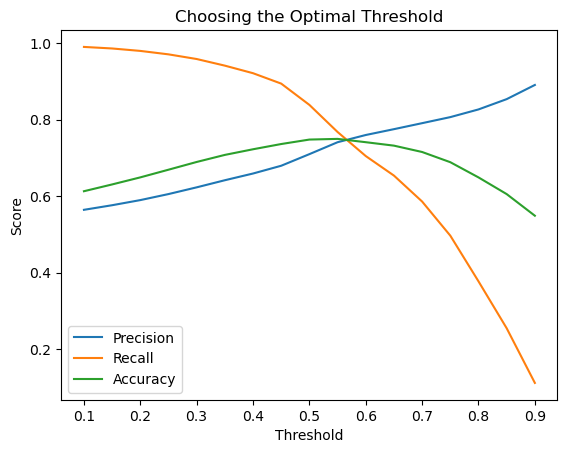

- Threshold: 0.35 | Accuracy: 0.708 | Precision: 0.642 | Recall: 0.942
- Threshold: 0.40 | Accuracy: 0.723 | Precision: 0.659 | Recall: 0.922
- Threshold: 0.45 | Accuracy: 0.737 | Precision: 0.680 | Recall: 0.895
- Threshold: 0.50 | Accuracy: 0.748 | Precision: 0.710 | Recall: 0.839
- Threshold: 0.55 | Accuracy: 0.750 | Precision: 0.741 | Recall: 0.768
- Threshold: 0.60 | Accuracy: 0.741 | Precision: 0.760 | Recall: 0.705
- Threshold: 0.65 | Accuracy: 0.732 | Precision: 0.775 | Recall: 0.654
- Threshold: 0.70 | Accuracy: 0.716 | Precision: 0.791 | Recall: 0.586


In [9]:
# list of possible threshold values
threshold_values = [i / 100 for i in range(10, 95, 5)]

# list to hold precision, recall, accuracy scores for each possible threshold value
prec_scores = []
rec_scores = []
acc_scores = []

for threshold in threshold_values:
    y_pred = (model.predict(val_x) > threshold).astype(int)
    prec_scores.append(precision_score(val_y, y_pred))
    rec_scores.append(recall_score(val_y, y_pred))
    acc_scores.append(accuracy_score(val_y, y_pred))
    
plt.plot(threshold_values, prec_scores, label='Precision')
plt.plot(threshold_values, rec_scores, label='Recall')
plt.plot(threshold_values, acc_scores, label='Accuracy')
plt.title('Choosing the Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

for i in range(len(threshold_values)):
     if acc_scores[i] > 0.7:
         print(f'- Threshold: {threshold_values[i]:.2f} | Accuracy: {acc_scores[i]:.3f} | Precision: {prec_scores[i]:.3f} | Recall: {rec_scores[i]:.3f}')

optimal_threshold = 0.45

## Model Evaluation

In [10]:
predictions = (model.predict(test_x) > optimal_threshold).astype(int)

442/442 [==============================] - 0s 872us/step


In [11]:
print(f'Accuracy:  {accuracy_score(test_y, predictions):.4f}')
print(f'Precision: {precision_score(test_y, predictions):.4f}')
print(f'Recall:    {recall_score(test_y, predictions):.4f}')
print(f'F1 Score:  {f1_score(test_y, predictions):.4f}')
print(f'AUC ROC:   {roc_auc_score(test_y, predictions):.4f}')

Accuracy:  0.7369
Precision: 0.6791
Recall:    0.8983
F1 Score:  0.7735
AUC ROC:   0.7369


In [12]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_y, predictions)
    )
disp.plot()
plt.title('M3 - Deep Neural Network')
plt.tight_layout()
plt.savefig('Output/CM - M3.png', bbox_inches='tight')
plt.close()